In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import pandas as pd
from keras.utils import plot_model
from keras import models
from keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_curve, auc, precision_score, accuracy_score, confusion_matrix

In [ ]:
def read_image(filepath):
    return cv2.imread(os.path.join(data_dir, filepath))

def resize_image(image, image_size):
    return cv2.resize(image.copy(), image_size, interpolation = cv2.INTER_AREA)

In [ ]:
disease_types=['COVID', 'NonCOVID']
data_dir = 'E:/DATA'
train_dir = os.path.join(data_dir)

In [ ]:
train_data = []
for defects_id, sp in enumerate(disease_types):
    for file in os.listdir(os.path.join(train_dir, sp)):
        train_data.append(['{}/{}'.format(sp, file), defects_id, sp])
train = pd.DataFrame(train_data, columns=['File', 'DiseaseID','Disease Type'])

In [ ]:
train.head(10000)

,File,DiseaseID,Disease Type
0,COVID/13_Bjorke_1.png,0,COVID
1,COVID/13_Bjorke_10.png,0,COVID
2,COVID/13_Bjorke_100.png,0,COVID
3,COVID/13_Bjorke_11.png,0,COVID
4,COVID/13_Bjorke_12.png,0,COVID
...,...,...,...
9995,NonCOVID/16_Morozov_study_0121_15.png,1,NonCOVID
9996,NonCOVID/16_Morozov_study_0121_16.png,1,NonCOVID
9997,NonCOVID/16_Morozov_study_0121_17.png,1,NonCOVID
9998,NonCOVID/16_Morozov_study_0121_18.png,1,NonCOVID


In [ ]:
IMAGE_SIZE = 64
X = np.zeros((train.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3))
for i, file in tqdm(enumerate(train['File'].values), total = len(train)):
    image = read_image(file)
    if image is not None:
        X[i] = resize_image(image, (IMAGE_SIZE, IMAGE_SIZE))
X /= 255.
y = train['DiseaseID'].values
print(X.shape)
print(y.shape)


(14486, 64, 64, 3)
(14486,)


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state = 1)

In [ ]:
from keras.applications import MobileNet

conv_base = MobileNet(weights='imagenet',
                  include_top=False,
                  input_shape=(64, 64, 3))

17227776/17225924 [==============================] - 52s 3us/step


In [ ]:
conv_base.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 32, 32, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 32, 32, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 32, 32, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 32, 32, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 32, 32, 32)        128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 32, 32, 32) 

In [ ]:
conv_base.trainable = True

In [ ]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Function (None, 2, 2, 1024)        3228864   
_________________________________________________________________
flatten_1 (Flatten)          (None, 4096)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               524416    
_________________________________________________________________
dense_5 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_6 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 33        
Total params: 3,763,649
Trainable params: 3,741,761
Non-trainable params: 21,888
_______________________________________

In [ ]:
for layer in model.layers :
  print(layer.name , '==>' , layer.trainable)

mobilenet_1.00_224 ==> True
flatten_1 ==> True
dense_4 ==> True
dense_5 ==> True
dense_6 ==> True
dense_7 ==> True


In [ ]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(x_train, y_train,
                    batch_size=64, epochs=30,steps_per_epoch=32,
                    verbose=1,validation_split=0.1)

Epoch 1/30
32/32 [==============================] - 44s 1s/step - loss: 0.7939 - accuracy: 0.6960 - val_loss: 1.3390 - val_accuracy: 0.6540
Epoch 2/30
32/32 [==============================] - 29s 920ms/step - loss: 0.3268 - accuracy: 0.8729 - val_loss: 2.4911 - val_accuracy: 0.5487
Epoch 3/30
32/32 [==============================] - 30s 943ms/step - loss: 0.2510 - accuracy: 0.8972 - val_loss: 2.9284 - val_accuracy: 0.5643
Epoch 4/30
32/32 [==============================] - 31s 962ms/step - loss: 0.3372 - accuracy: 0.8514 - val_loss: 0.9032 - val_accuracy: 0.7463
Epoch 5/30
32/32 [==============================] - 31s 986ms/step - loss: 0.2888 - accuracy: 0.9065 - val_loss: 0.8839 - val_accuracy: 0.8136
Epoch 6/30
32/32 [==============================] - 31s 975ms/step - loss: 0.2407 - accuracy: 0.9110 - val_loss: 1.2040 - val_accuracy: 0.7998
Epoch 7/30
32/32 [==============================] - 32s 990ms/step - loss: 0.2276 - accuracy: 0.9187 - val_loss: 0.5655 - val_accuracy: 0.8827
Ep

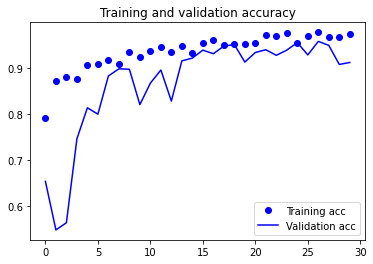

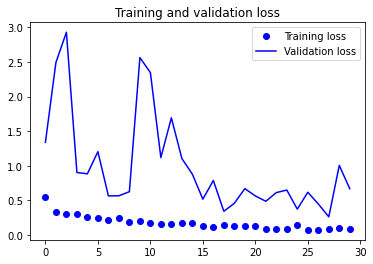

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

In [ ]:
y_pred = model.predict_classes(x_test)

In [ ]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

In [ ]:
sp = tn/(tn+fp)
sn = tp/(tp+fn)

print('f1 score =  %.3f'%f1_score(y_test, y_pred))
print('Precision =  %.3f'%precision_score(y_test, y_pred))
print('Test accuracy =  %.3f'%accuracy_score(y_test, y_pred))
print('Specificity =  %.3f'%sp)
print('Sensitivity =  %.3f'%sn)

f1 score =  0.913
Precision =  0.841
Test accuracy =  0.910
Specificity =  0.829
Sensitivity =  0.999
